In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

In [3]:
trader_df = pd.read_csv("historical_data.csv")
sentiment_df = pd.read_csv("fear_greed_index.csv")

print("Trader Data Shape:", trader_df.shape)
print("Sentiment Data Shape:", sentiment_df.shape)

print(trader_df.head())
print(sentiment_df.head())

print(trader_df.info())
print(sentiment_df.info())


Trader Data Shape: (211224, 16)
Sentiment Data Shape: (2644, 4)
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                           

In [5]:
#preprocess trader data

trader_df["Timestamp"] = pd.to_datetime(trader_df["Timestamp"], unit="ms")
trader_df["date"] = trader_df["Timestamp"].dt.date
daily_pnl = trader_df.groupby(["date", "Account"])["Closed PnL"].sum().reset_index(name="dailyPnL")
daily_size = trader_df.groupby(["date", "Account"])["Size USD"].mean().reset_index(name="avgTradeSizeUSD")
trader_df["profitable"] = (trader_df["Closed PnL"] > 0).astype(int)
daily_winrate = trader_df.groupby(["date", "Account"])["profitable"].mean().reset_index(name="winRate")

trader_features = daily_pnl.merge(daily_size, on=["date","Account"]).merge(daily_winrate, on=["date","Account"])
print("Trader Features Shape:", trader_features.shape)
print(trader_features.head())

Trader Features Shape: (102, 5)
         date                                     Account     dailyPnL  \
0  2023-03-28  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891     0.000000   
1  2023-11-14  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891     0.000000   
2  2023-11-14  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23   155.503357   
3  2024-03-09  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891 -5564.016140   
4  2024-03-09  0x430f09841d65beb3f27765503d0f850b8bce7713     0.000000   

   avgTradeSizeUSD   winRate  
0       159.000000  0.000000  
1     23066.935000  0.000000  
2     11034.799511  0.275168  
3      3048.594444  0.333333  
4      1136.312727  0.000000  


In [6]:
#preprocess sentiment data

sentiment_df["date"] = pd.to_datetime(sentiment_df["date"]).dt.date
sentiment_map = {
    "Extreme Fear": -2,
    "Fear": -1,
    "Neutral": 0,
    "Greed": 1,
    "Extreme Greed": 2
}
sentiment_df["sentiment_score"] = sentiment_df["classification"].map(sentiment_map)

print(sentiment_df.head())

    timestamp  value classification        date  sentiment_score
0  1517463000     30           Fear  2018-02-01               -1
1  1517549400     15   Extreme Fear  2018-02-02               -2
2  1517635800     40           Fear  2018-02-03               -1
3  1517722200     24   Extreme Fear  2018-02-04               -2
4  1517808600     11   Extreme Fear  2018-02-05               -2


In [8]:
merged_df = trader_features.merge(sentiment_df[["date","sentiment_score"]], on="date", how="left")

print("Merged Data Shape:", merged_df.shape)
print(merged_df.head())
merged_df.to_csv("merged_trader_sentiment.csv", index=False)
print("Merged dataset saved")

Merged Data Shape: (102, 6)
         date                                     Account     dailyPnL  \
0  2023-03-28  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891     0.000000   
1  2023-11-14  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891     0.000000   
2  2023-11-14  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23   155.503357   
3  2024-03-09  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891 -5564.016140   
4  2024-03-09  0x430f09841d65beb3f27765503d0f850b8bce7713     0.000000   

   avgTradeSizeUSD   winRate  sentiment_score  
0       159.000000  0.000000              1.0  
1     23066.935000  0.000000              1.0  
2     11034.799511  0.275168              1.0  
3      3048.594444  0.333333              2.0  
4      1136.312727  0.000000              2.0  
Merged dataset saved ✅


Mean PnL by Sentiment:
sentiment_score
-1.0    209372.662205
 0.0     19842.797260
 1.0     99675.516731
 2.0     35393.098355
Name: dailyPnL, dtype: float64 

Mean WinRate by Sentiment:
sentiment_score
-1.0    0.415878
 0.0    0.260683
 1.0    0.374074
 2.0    0.336609
Name: winRate, dtype: float64 

Average Trade Size by Sentiment:
sentiment_score
-1.0    5926.522723
 0.0    3793.444161
 1.0    5839.310974
 2.0    4344.447836
Name: avgTradeSizeUSD, dtype: float64 

Correlation Matrix:
                  dailyPnL  avgTradeSizeUSD   winRate  sentiment_score
dailyPnL         1.000000         0.148349  0.156276        -0.181416
avgTradeSizeUSD  0.148349         1.000000  0.043632        -0.028403
winRate          0.156276         0.043632  1.000000        -0.094091
sentiment_score -0.181416        -0.028403 -0.094091         1.000000


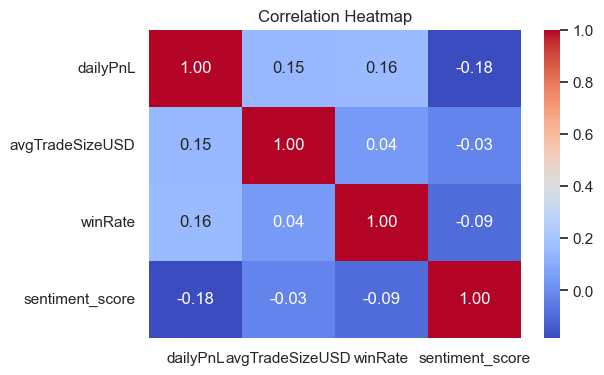

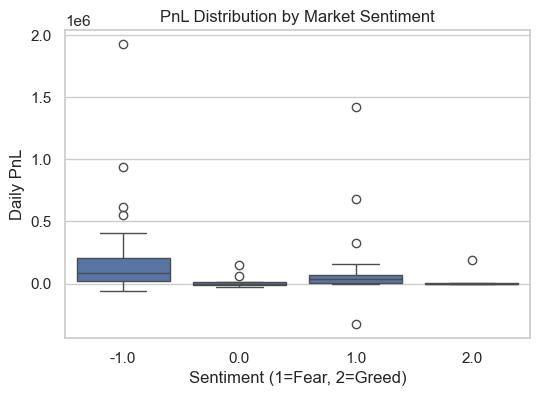

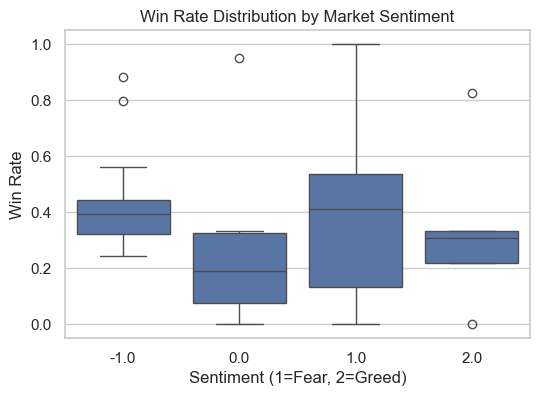

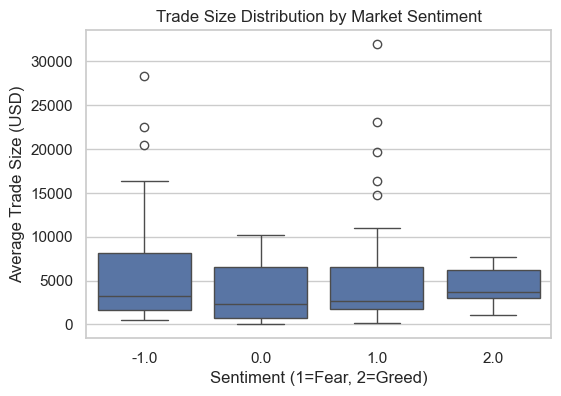

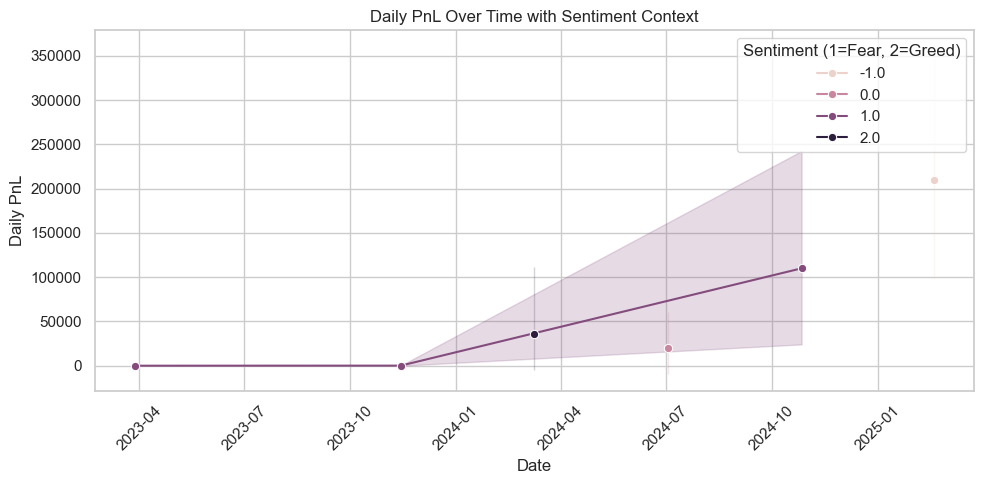

In [9]:
print("Mean PnL by Sentiment:")
print(merged_df.groupby("sentiment_score")["dailyPnL"].mean(), "\n")

print("Mean WinRate by Sentiment:")
print(merged_df.groupby("sentiment_score")["winRate"].mean(), "\n")

print("Average Trade Size by Sentiment:")
print(merged_df.groupby("sentiment_score")["avgTradeSizeUSD"].mean(), "\n")

corr = merged_df[["dailyPnL", "avgTradeSizeUSD", "winRate", "sentiment_score"]].corr()
print("Correlation Matrix:\n", corr)

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x="sentiment_score", y="dailyPnL", data=merged_df)
plt.title("PnL Distribution by Market Sentiment")
plt.xlabel("Sentiment (1=Fear, 2=Greed)")
plt.ylabel("Daily PnL")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x="sentiment_score", y="winRate", data=merged_df)
plt.title("Win Rate Distribution by Market Sentiment")
plt.xlabel("Sentiment (1=Fear, 2=Greed)")
plt.ylabel("Win Rate")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x="sentiment_score", y="avgTradeSizeUSD", data=merged_df)
plt.title("Trade Size Distribution by Market Sentiment")
plt.xlabel("Sentiment (1=Fear, 2=Greed)")
plt.ylabel("Average Trade Size (USD)")
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(x="date", y="dailyPnL", hue="sentiment_score", data=merged_df, marker="o")
plt.title("Daily PnL Over Time with Sentiment Context")
plt.xlabel("Date")
plt.ylabel("Daily PnL")
plt.xticks(rotation=45)
plt.legend(title="Sentiment (1=Fear, 2=Greed)")
plt.tight_layout()
plt.show()
